# Notes on SDSS DR7 (v2)
    At the heart is a home-brew QSO sample by JXP

In [32]:
%matplotlib notebook

In [5]:
# imports
from linetools.spectra import io as lsio
from specdb.specdb import IgmSpec

## Database

Here is the SQL:
    
    SQL query

    SELECT s.ra, s.dec,
            s.fiberID, s.mjd, s.plate,      -- spectro info for DAS upload
            s.SpecClass,       -- and spectral classification
            s.specObjID,     -- get the spectroscopic object id
            s.z, s.zErr, s.zConf,        -- redshift, redshift confidence
            p.psfMag_u,p.psfMagerr_u,
            p.psfMag_g,p.psfMagerr_g,
            p.psfMag_r,p.psfMagerr_r,
            p.psfMag_i,p.psfMagerr_i,
            p.psfMag_z,p.psfMagerr_z
    FROM SpecObj as s          -- from the spectroscopic objects
         JOIN PhotoObj as p ON s.bestobjid = p.objid -- from the photometric objects
    WHERE
        -- use a function to translate SpecClass bits to names; want quasars
        (SpecClass=dbo.fSpecClass('QSO')
        or SpecClass=dbo.fSpecClass('HIZ_QSO'))
        and s.z between 0 and 0.5
        and s.z between 0.5 and 1.0
        and s.z between 1.0 and 1.5
        and s.z between 1.5 and 1.8
        and s.z between 1.8 and 2.2
        and s.z between 2.2 and 2.5
        and s.z between 2.5 and 3.0
        and s.z between 3.0 and 8.0


## Schneider DR7
    http://classic.sdss.org/dr7/products/value_added/qsocat_dr7.html
    
    Grabbed dr7qso.fit.gz on 26 Aug 2016

In [2]:
dr7qso = Table.read(os.getenv('RAW_IGMSPEC')+'/SDSS/dr7qso.fit.gz')

In [3]:
dr7qso[0:3]

SDSSJ,RA,DEC,z,UMAG,UMAGERR,GMAG,GMAGERR,RMAG,RMAGERR,IMAG,IMAGERR,ZMAG,ZMAGERR,AU,logNH,FIRSTMAG,FIRSTSN,FIRSTDEL,RASSCNT,RASSSN,RASSDEL,JMAG,JMAGERR,HMAG,HMAGERR,KMAG,KMAGERR,MASSDEL,MASSFLG,MIMAG,DGMI,MFLAG,SPFLAG,MODEFLAG,USELFLAG,BESTFLAG,LZFLAG,HZFLAG,FTFLAG,RTFLAG,SRFLAG,STFLAG,GXFLAG,RUN,RMJD,SMJD,PLATE,FIBER,RERUN,CAMCOL,FIELD,OBJECT,TFLAG,LZTFLAG,HZTFLAG,FTTFLAG,RTTFLAG,SRTFLAG,STTFLAG,GXTFLAG,UTMAG,UTMAGERR,GTMAG,GTMAGERR,RTMAG,RTMAGERR,ITMAG,ITMAGERR,ZTMAG,ZTMAGERR,BESTID,SPECOID,ONAME
str31,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str31,str31,str31
000006.53+003055.2,0.027228,0.515341,1.8246,20.384,0.065,20.461,0.034,20.324,0.038,20.093,0.041,20.042,0.121,0.13,20.508,0.0,0.0,0.0,-9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-25.109,0.091,0,0,1,0,34603008,0,0,0,0,1,0,0,3325,52522,52203,685,467,41,5,108,118,34603008,0,0,0,0,1,0,0,20.384,0.065,20.461,0.034,20.324,0.038,20.093,0.041,20.042,0.121,588015509806252150,193034571183292416,SDSS J000006.53+003055.2
000008.13+001634.6,0.0339,0.276301,1.8373,20.242,0.054,20.206,0.024,19.941,0.032,19.485,0.032,19.178,0.068,0.161,20.502,0.0,0.0,0.0,-9.0,0.0,0.0,17.351,0.291,0.0,0.0,0.0,0.0,0.0,18,-25.745,0.438,0,0,1,0,34603008,0,0,0,0,1,0,0,2662,52197,52203,685,470,40,4,283,150,1048576,0,0,0,0,1,0,0,20.094,0.044,19.98,0.017,19.852,0.02,19.405,0.021,19.1,0.079,587731186740822166,193034571195875328,SDSS J000008.13+001634.6
000009.26+151754.5,0.038604,15.298477,1.1985,19.916,0.042,19.807,0.036,19.374,0.017,19.148,0.023,19.312,0.069,0.223,20.551,-1.0,0.0,0.0,-9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-25.101,0.338,0,1,1,1,1048578,1,0,0,0,1,0,0,1739,51814,52251,751,354,40,4,303,24,1048578,1,0,0,0,1,0,0,19.912,0.037,19.77,0.024,19.393,0.018,19.173,0.019,19.353,0.07,587727222487318552,211612125330669568,SDSS J000009.26+151754.5


In [4]:
len(dr7qso)

105783

### Compare against JXP set

In [6]:
igmsp = IgmSpec()

Using /raid/IGMSPEC_DB/IGMspec_DB_v02.hdf5 for the catalog file
Using /raid/IGMSPEC_DB/IGMspec_DB_v02.hdf5 for the DB file
Available surveys: [u'GGG', u'HD-LLS_DR1', u'HST_z2', u'KODIAQ_DR1', u'SDSS_DR7', u'XQ-100']


In [8]:
jxp_sdss = Table(igmsp.idb.hdf['SDSS_DR7/meta'].value)

In [9]:
jxp_sdss[0:3]

zem,sig_zem,Z_CONF,Z_WARN,PLATE,MJD,FIBERID,FLG_TARG,RA,DEC,PSF_U,PSF_G,PSF_R,PSF_I,PSF_Z,PSF_SU,PSF_SG,PSF_SR,PSF_SI,PSF_SZ,DATE-OBS,EPOCH,R,IGM_ID,SPEC_FILE,NPIX,WV_MIN,WV_MAX,SURVEY_ID,INSTR,GRATING,TELESCOPE
float32,float32,float32,int16,int32,int32,int32,int16,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str10,float64,float64,int64,str28,int64,float64,float64,int64,str4,str4,str10
1.19851,0.000990054,0.0,0,751,52251,354,0,0.0386095,15.298489,19.9162,19.8067,19.3741,19.1477,19.3124,0.041842,0.035909,0.016587,0.022998,0.068749,2001-12-08,2000.0,2000.0,297301,spSpec-52251-0751-354.fit.gz,3828,3817.68419498,9215.09888735,0,SDSS,BOTH,SDSS 2.5-M
2.23419,0.00146079,0.0,0,750,52235,82,0,0.03909926,13.938458,19.2332,18.8861,18.4268,18.3014,18.0839,0.025944,0.02224,0.018289,0.023856,0.032778,2001-11-22,2000.0,2000.0,47,spSpec-52235-0750-082.fit.gz,3841,3804.5211258,9210.85615448,1,SDSS,BOTH,SDSS 2.5-M
1.84493,0.00199866,0.0,0,650,52143,199,0,0.03926445,-10.46441,19.2416,19.0187,18.9659,18.7754,18.7046,0.035869,0.027196,0.021356,0.018248,0.046806,2001-08-22,2000.0,2000.0,297302,spSpec-52143-0650-199.fit.gz,3836,3802.76948244,9196.02196659,2,SDSS,BOTH,SDSS 2.5-M


In [12]:
dr7_plateID = dr7qso['PLATE']*1000 + dr7qso['FIBER']
jxp_plateID = jxp_sdss['PLATE']*1000 + jxp_sdss['FIBERID']

In [14]:
good = np.in1d(dr7_plateID, jxp_plateID)

In [18]:
np.sum(~good)

12012

### Generate the file to download the missing ones

In [26]:
need_tbl = dr7qso[['PLATE','SMJD','FIBER']][~good]

In [27]:
# First 9999 then rest
need_tbl[0:5999].write(os.getenv('RAW_IGMSPEC')+'/SDSS/dr7_neededA.csv')
need_tbl[5999:].write(os.getenv('RAW_IGMSPEC')+'/SDSS/dr7_neededB.csv')

### Grabbing
    Comment out first line
    Use this web page:  http://das.sdss.org/www/html/post_fibers.html

## Zhu Continua

In [1]:
cfile = os.getenv('RAW_IGMSPEC')+'/SDSS/ALLQSO_SPEC_106_continuum_nointerp.fits'

In [2]:
conti = Table.read(cfile)

In [3]:
conti[0:3]

"CONTINUUM [3955,107194]",RA [107194],DEC [107194],PLATE [107194],FIBER [107194],MJD [107194],ZQSO [107194],ERR_ZQSO [107194],SPEC_SNR_MEDIAN [107194],ISITDECOMPOSED [107194],MED_SDEVIATION_RED [107194],MED_SDEVIATION_BLUE [107194]
float32,float64,float64,int32,int32,int32,float32,float32,float32,uint8,float32,float32
5.04552 .. 0.0,0.027228 .. 359.997675,0.515341 .. 0.14487,685 .. 1489,467 .. 520,52203 .. 52991,1.82383 .. 1.35685,0.00333 .. 0.001825,3.94727 .. 2.91944,1 .. 1,0.0498405 .. 0.0747612,0.0554914 .. -999.0


In [39]:
conti['CONTINUUM'][0].shape

(3955, 107194)

In [9]:
wv_file = os.getenv('RAW_IGMSPEC')+'/SDSS/ALLQSO_SPEC_106_wave_nointerp.fits'

In [10]:
zhu_wave = Table.read(wv_file)

In [15]:
zhu_wave[0:3]

"WAVE [3955,107194]",RA [107194],DEC [107194],PLATE [107194],FIBER [107194],MJD [107194],ZQSO [107194],ERR_ZQSO [107194],SPEC_SNR_MEDIAN [107194],ISITDECOMPOSED [107194],MED_SDEVIATION_RED [107194],MED_SDEVIATION_BLUE [107194]
float32,float64,float64,int32,int32,int32,float32,float32,float32,uint8,float32,float32
3795.77 .. 1.0,0.027228 .. 359.997675,0.515341 .. 0.14487,685 .. 1489,467 .. 520,52203 .. 52991,1.82383 .. 1.35685,0.00333 .. 0.001825,3.94727 .. 2.91944,1 .. 1,0.0498405 .. 0.0747612,0.0554914 .. -999.0


### Test

In [43]:
plate=1473
fiber=304
mtc = (conti['PLATE'] == plate) & (conti['FIBER']==fiber)
np.sum(mtc)

1

In [44]:
conti['MJD'][mtc]

52908


In [45]:
mtw = (zhu_wave['PLATE'] == plate) & (zhu_wave['FIBER']==fiber)
np.sum(mtw)

1

In [50]:
#spec = lsio.readspec(os.getenv('RAW_IGMSPEC')+'/SDSS/Schneider/spSpec-52908-1473-613.fit.gz')
spec = lsio.readspec(os.getenv('RAW_IGMSPEC')+'/SDSS/Schneider/spSpec-52908-1473-304.fit.gz')

In [51]:
imin = np.argmin(np.abs(zhu_wave['WAVE'][0,:,np.where(mtw)[0]]-spec.wavelength[0].value))
zhu_wave['WAVE'][0,imin,np.where(mtw)[0]].data,spec.wavelength[0].value

(array([ 3826.48413086], dtype=float32), 3826.484865951097)

In [52]:
zhu_wave['WAVE'][0,:,np.where(mtw)[0]]

3795.77 .. 1.0


### Plot

In [56]:
conti['PLATE'][mtc].data, conti['FIBER'][mtc].data

(array([1473], dtype=int32), array([304], dtype=int32))

In [68]:
np.where(mtc)

(array([0]), array([102734]))

In [69]:
conti['CONTINUUM'][0][:,np.where(mtc)[1]]

array([[ 11.25391293],
       [ 11.25391293],
       [ 11.25391293],
       ..., 
       [  0.        ],
       [  0.        ],
       [  0.        ]], dtype=float32)

<IPython.core.display.Javascript object>


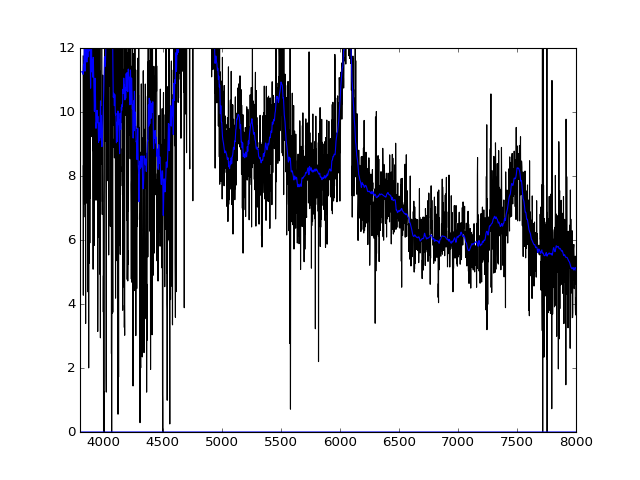

In [70]:
plt.clf()
ax = plt.gca()
# Data
ax.plot(spec.wavelength, spec.flux, 'k')
# Continuum
ax.plot(zhu_wave['WAVE'][0][:,np.where(mtw)[0]], conti['CONTINUUM'][0][:,np.where(mtc)[1]])
ax.set_xlim(3800., 8000.)
ax.set_ylim(0., 12)
plt.show()